參考資料
https://github.com/emadRad/lstm-gru-pytorch/blob/master/lstm_gru.ipynb

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math


cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [2]:
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [3]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# GRU cell implmentation

In [ ]:
class GRUCell(nn.Module):

    """
    An implementation of GRUCell.

    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()



    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x) 
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        
        
        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        
        
        return hy

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
         
       
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        
        
        self.fc = nn.Linear(hidden_dim, output_dim)
     
    
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
         
       
        outs = []
        
        hn = h0[0,:,:]
        
        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:,seq,:], hn) 
            outs.append(hn)
            

        out = outs[-1].squeeze()
        
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

# LSTM cell implementation

In [4]:
class LSTMCell(nn.Module):

    """
    An implementation of Hochreiter & Schmidhuber:
    'Long-Short Term Memory' cell.
    http://www.bioinf.jku.at/publications/older/2604.pdf

    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()



    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        hx, cx = hidden
        
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
    
        gates = gates.squeeze()
        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)
        

        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)        

        hy = torch.mul(outgate, F.tanh(cy))
        
        return (hy, cy)

In [ ]:
'''
STEP 3: CREATE MODEL CLASS
'''
 
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
               
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)  
        
        self.fc = nn.Linear(hidden_dim, output_dim)
     
    
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        # Initialize cell state
        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

                    
       
        outs = []
        
        cn = c0[0,:,:]
        hn = h0[0,:,:]

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) 
            outs.append(hn)
            
    

        out = outs[-1].squeeze()
        
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [12]:
'''
STEP 3: CREATE MODEL CLASS
'''
 
class LSTMModelMulti(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModelMulti, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
               
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)  
        self.lstm2 = LSTMCell(hidden_dim, hidden_dim, layer_dim)  
        
        self.fc = nn.Linear(hidden_dim, output_dim)
     
    
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        # Initialize cell state
        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

                    
       
        outs = []
        
        cn = c0[0,:,:]
        hn = h0[0,:,:]
        cm = c0[0,:,:]
        hm = h0[0,:,:]        

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) 
            hm, cm = self.lstm2(hn, (hm,cm))
            #outs.append(hn)
            out = hm
            
    

        #out = outs[-1].squeeze()
        
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [13]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10
 
#model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model = LSTMModelMulti(input_dim, hidden_dim, layer_dim, output_dim)
#model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()
     
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()
 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
'''
STEP 7: TRAIN THE MODEL
'''
 
# Number of steps to unroll
seq_dim = 28 

loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
          
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
          
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list.append(loss.item())
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2838926315307617. Accuracy: 11
Iteration: 1000. Loss: 1.8743503093719482. Accuracy: 33
Iteration: 1500. Loss: 0.8423241972923279. Accuracy: 77
Iteration: 2000. Loss: 0.43736571073532104. Accuracy: 88
Iteration: 2500. Loss: 0.1772366762161255. Accuracy: 95
Iteration: 3000. Loss: 0.2988511919975281. Accuracy: 95
Iteration: 3500. Loss: 0.06947170197963715. Accuracy: 96
Iteration: 4000. Loss: 0.052828215062618256. Accuracy: 96
Iteration: 4500. Loss: 0.046077221632003784. Accuracy: 97
Iteration: 5000. Loss: 0.09533368796110153. Accuracy: 97
Iteration: 5500. Loss: 0.07538185268640518. Accuracy: 97
Iteration: 6000. Loss: 0.1616125851869583. Accuracy: 97


In [15]:
predicted

tensor([8, 9, 0, 1, 5, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 9, 1,
        9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 9, 9, 1, 4,
        5, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2,
        4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 3, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6], device='cuda:0')

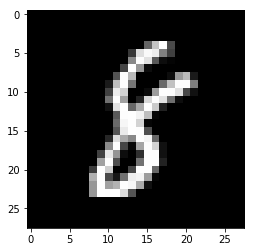

In [16]:
plt.imshow(images[0].cpu(), cmap='gray')

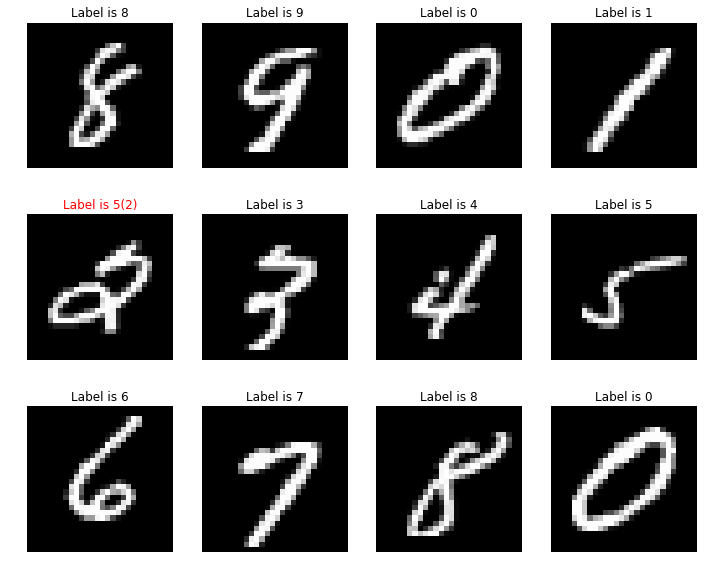

In [17]:
plt.figure(figsize=(12,10)) 

def plot_mnist(index):
    ax = plt.subplot(3,4,index+1) 
    plt.axis('off')
    if predicted[index].cpu() == labels[index]:
        plt.title('Label is {pred}'.format(pred=predicted[index].cpu()))
    else:
        plt.title('Label is {pred}({label})'.format(pred=predicted[index].cpu(),label=labels[index]), color='red')

    plt.imshow(images[index].cpu(), cmap='gray') 
    
for i,data in enumerate(images,0): 
    if i == 3: break 
    plot_mnist(0+i*4)
    plot_mnist(1+i*4)
    plot_mnist(2+i*4)
    plot_mnist(3+i*4)
